# Data Analytics for Health - Task 1.1: Exploratory Data Analysis

## Overview
This notebook performs exploratory data analysis (EDA) on four healthcare datasets:
1. **Heart Diagnoses** - Clinical notes and patient information
2. **Laboratory Events Codes** - Lab test results and measurements  
3. **Microbiology Events Codes** - Microbiology test results
4. **Procedure Codes** - Medical procedures and ICD codes

## Objectives
- Load and examine the structure of all four datasets
- Perform data understanding and quality assessment
- Create meaningful distribution plots for key variables
- Identify patterns and characteristics in the healthcare data

---

In [ ]:
# Import required libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
from datetime import datetime

# Configure settings
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")

# Set up file paths
notebook_dir = Path.cwd().resolve()
data_path = (notebook_dir / '..' / '..' / 'Data').resolve()
out_dir = (notebook_dir / '..' / 'plots').resolve()
out_dir.mkdir(parents=True, exist_ok=True)

print("✅ Libraries imported successfully")
print(f"📁 Data path: {data_path}")
print(f"📊 Output directory: {out_dir}")

✅ Libraries imported successfully
📁 Data path: /Users/alexandermittet/Library/Mobile Documents/com~apple~CloudDocs/uni_life/UniPi DAD/Data
📊 Output directory: /Users/alexandermittet/Library/Mobile Documents/com~apple~CloudDocs/uni_life/UniPi DAD/data_analytics_4_health_unipi/plots
Loading heart_diagnoses_1.csv:
          note_id  subject_id   hadm_id note_type  note_seq  \
0  10000980-DS-20    10000980  29654838        DS        20   
1  10000980-DS-21    10000980  26913865        DS        21   
2   10002013-DS-8    10002013  24760295        DS         8   
3   10002155-DS-8    10002155  23822395        DS         8   
4  10004457-DS-10    10004457  28723315        DS        10   

             charttime            storetime  \
0  2188-01-06 03:00:00  2188-01-07 23:49:00   
1  2189-07-04 03:00:00  2189-07-04 22:50:00   
2  2160-07-13 03:00:00  2160-07-15 16:59:00   
3  2129-08-19 03:00:00  2129-08-20 15:29:00   
4  2141-08-14 03:00:00  2141-08-14 21:50:00   

                         

## 1. Data Loading

We'll load all four datasets and examine their basic structure to understand what we're working with.


In [36]:
# Load all four datasets
datasets = {
    "Heart Diagnoses": "heart_diagnoses_1.csv",
    "Laboratory Events": "laboratory_events_codes_2.csv", 
    "Microbiology Events": "microbiology_events_codes_3.csv",
    "Procedure Codes": "procedure_code_4.csv"
}

# Load datasets into DataFrames
dfs = {}
for name, filename in datasets.items():
    filepath = data_path / filename
    dfs[name] = pd.read_csv(filepath)
    print(f"✅ Loaded {name}: {dfs[name].shape[0]:,} rows × {dfs[name].shape[1]} columns")

# Assign to individual variables for convenience
df1 = dfs["Heart Diagnoses"]  # heart_diagnoses
df2 = dfs["Laboratory Events"]  # laboratory_events
df3 = dfs["Microbiology Events"]  # microbiology_events  
df4 = dfs["Procedure Codes"]  # procedure_codes

print(f"\n📊 All datasets loaded successfully!")


✅ Loaded Heart Diagnoses: 4,864 rows × 25 columns
✅ Loaded Laboratory Events: 978,503 rows × 14 columns
✅ Loaded Microbiology Events: 15,587 rows × 14 columns
✅ Loaded Procedure Codes: 14,497 rows × 6 columns

📊 All datasets loaded successfully!


## 2. Data Understanding

Let's examine the structure, data types, and basic characteristics of each dataset to understand what we're working with.


In [37]:
# Comprehensive data overview for all datasets
def analyze_dataset(df, name):
    """Analyze a single dataset and return key information"""
    print(f"\n{'='*60}")
    print(f"📋 {name.upper()}")
    print(f"{'='*60}")
    
    # Basic info
    print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
    print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # Data types
    print(f"\n📊 Data Types:")
    dtype_counts = df.dtypes.value_counts()
    for dtype, count in dtype_counts.items():
        print(f"  {dtype}: {count} columns")
    
    # Missing values
    missing = df.isnull().sum()
    missing_pct = (missing / len(df) * 100).round(2)
    
    print(f"\n❓ Missing Values:")
    if missing.sum() == 0:
        print("  No missing values")
    else:
        missing_summary = pd.DataFrame({
            'Missing Count': missing,
            'Missing %': missing_pct
        }).sort_values('Missing Count', ascending=False)
        print(missing_summary[missing_summary['Missing Count'] > 0].head(10))
    
    # Sample data
    print(f"\n👀 Sample Data:")
    print(df.head(3).to_string())
    
    return {
        'shape': df.shape,
        'dtypes': df.dtypes,
        'missing': missing,
        'sample': df.head(3)
    }

# Analyze all datasets
dataset_info = {}
for name, df in dfs.items():
    dataset_info[name] = analyze_dataset(df, name)

print(f"\n🎯 Summary: Analyzed {len(dataset_info)} datasets")



📋 HEART DIAGNOSES
Shape: 4,864 rows × 25 columns
Memory usage: 31.11 MB

📊 Data Types:
  object: 19 columns
  int64: 4 columns
  float64: 2 columns

❓ Missing Values:
                 Missing Count  Missing %
dod                       4466      91.82
anchor_year               3501      71.98
age                       3501      71.98
gender                    3501      71.98
chief_complaint             12       0.25
invasions                   12       0.25

👀 Sample Data:
          note_id  subject_id   hadm_id note_type  note_seq            charttime            storetime                                                                                                                                                                                                                                                                                                                                                                                                                                     

## 3. Distribution Analysis

Now we'll create distribution plots for numerical variables in each dataset to understand the data patterns and characteristics.


In [38]:
# Utility function to create clean distribution plots
def create_distribution_plots(df, dataset_name, max_vars=4):
    """
    Create distribution plots for numerical variables in a dataset
    
    Parameters:
    - df: DataFrame to analyze
    - dataset_name: Name for the plot title and filename
    - max_vars: Maximum number of variables to plot
    """
    
    # Get numerical columns, excluding ID-like columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Filter out ID-like columns (high cardinality)
    suitable_vars = []
    for col in numeric_cols:
        unique_ratio = df[col].nunique() / len(df)
        if unique_ratio < 0.8:  # Less than 80% unique values
            suitable_vars.append(col)
    
    if not suitable_vars:
        print(f"⚠️  No suitable numerical variables found in {dataset_name}")
        return
    
    # Limit number of variables
    suitable_vars = suitable_vars[:max_vars]
    
    # Create subplots
    n_vars = len(suitable_vars)
    if n_vars == 1:
        fig, axes = plt.subplots(1, 1, figsize=(10, 6))
        axes = [axes]
    elif n_vars == 2:
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    elif n_vars == 3:
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    else:
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        axes = axes.flatten()
    
    fig.suptitle(f'Distribution Analysis - {dataset_name}', fontsize=16, fontweight='bold')
    
    for i, col in enumerate(suitable_vars):
        ax = axes[i]
        data = df[col].dropna()
        
        if len(data) > 0:
            # Create histogram
            ax.hist(data, bins=30, alpha=0.7, density=True, color='skyblue', edgecolor='black')
            
            # Add statistics
            mean_val = data.mean()
            std_val = data.std()
            ax.axvline(mean_val, color='red', linestyle='--', alpha=0.8, label=f'Mean: {mean_val:.2f}')
            
            ax.set_title(f'{col}\\n(n={len(data):,}, μ={mean_val:.2f}, σ={std_val:.2f})')
            ax.set_xlabel(col)
            ax.set_ylabel('Density')
            ax.grid(True, alpha=0.3)
            ax.legend()
        else:
            ax.text(0.5, 0.5, 'No data to plot', ha='center', va='center', transform=ax.transAxes)
    
    # Hide empty subplots
    for i in range(len(suitable_vars), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    
    # Save plot
    try:
        filename = f"{dataset_name.lower().replace(' ', '_')}_distributions.jpg"
        filepath = out_dir / filename
        fig.savefig(filepath, dpi=200, bbox_inches='tight')
        print(f"💾 Saved: {filename}")
    except Exception as e:
        print(f"❌ Could not save plot: {e}")
    
    plt.show()
    
    return suitable_vars

print("🎨 Distribution plotting function ready!")


🎨 Distribution plotting function ready!


🎨 Creating distribution plots for all datasets...

📊 Analyzing Heart Diagnoses...
💾 Saved: heart_diagnoses_distributions.jpg


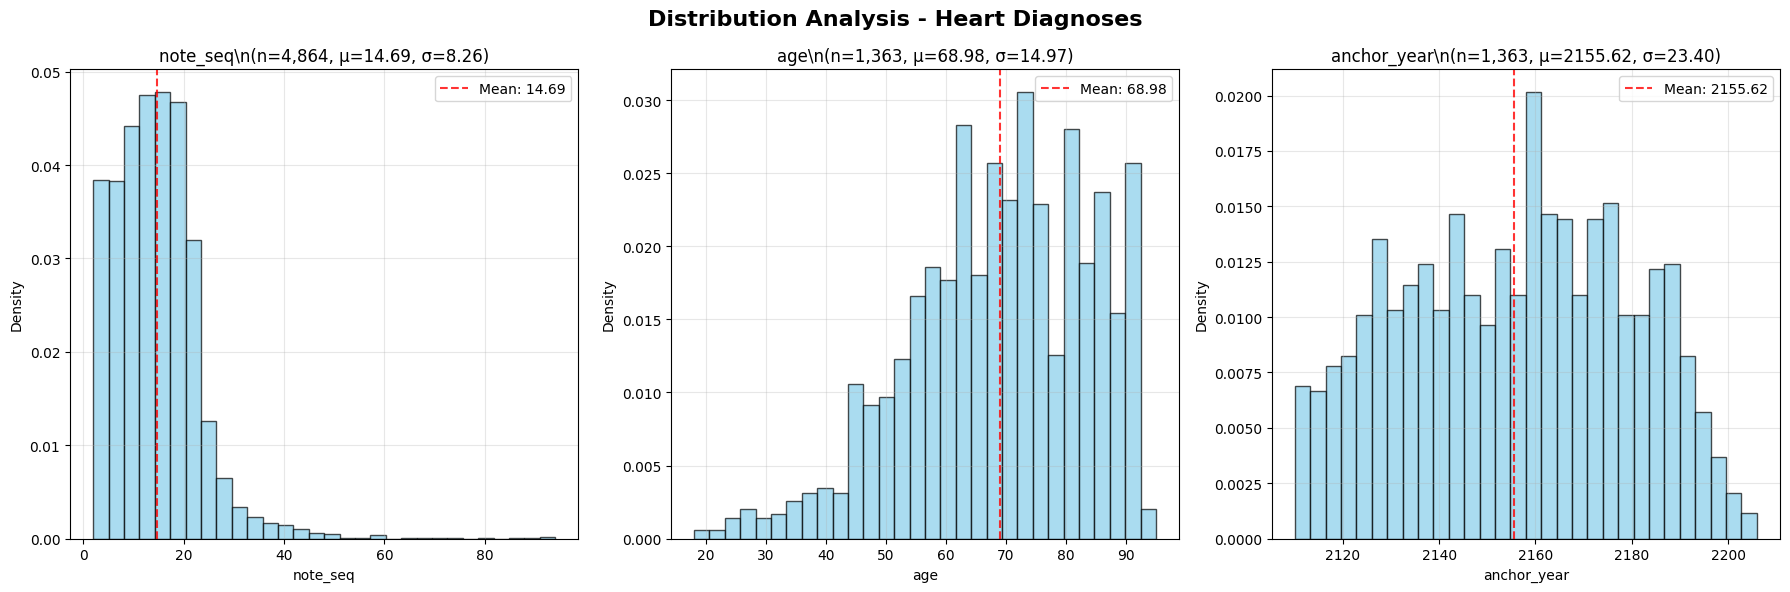


📊 Analyzing Laboratory Events...
💾 Saved: laboratory_events_distributions.jpg


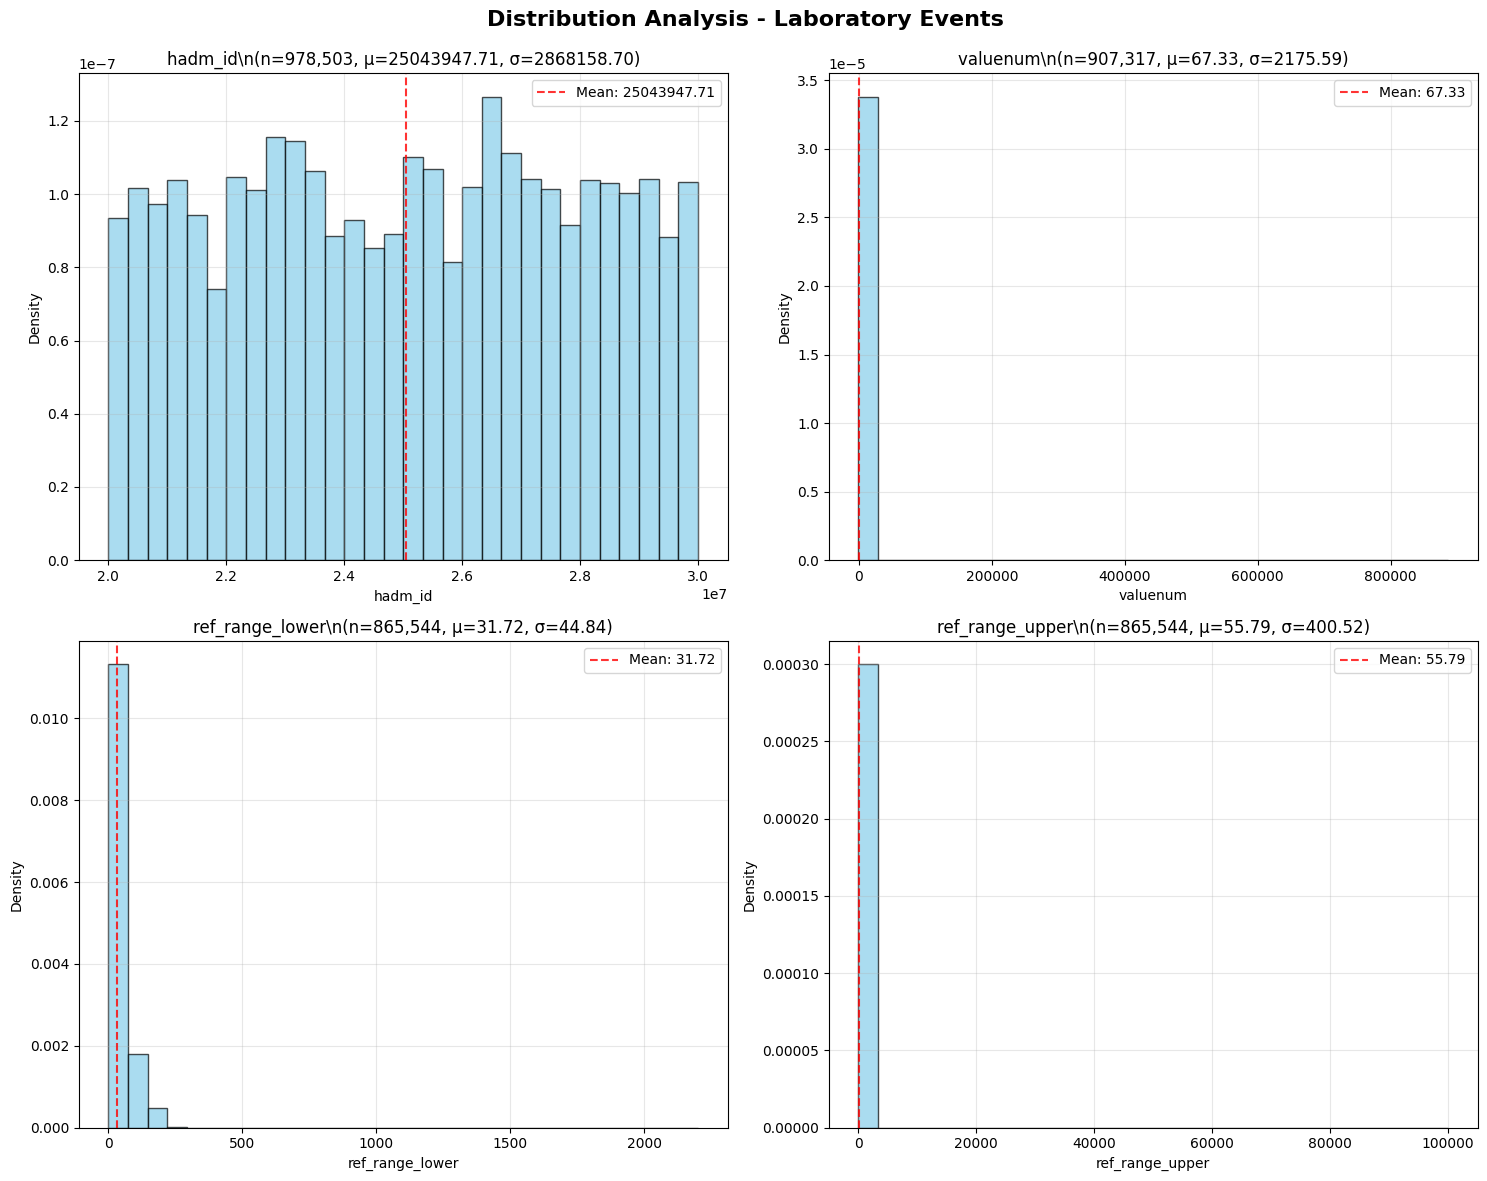


📊 Analyzing Microbiology Events...
💾 Saved: microbiology_events_distributions.jpg


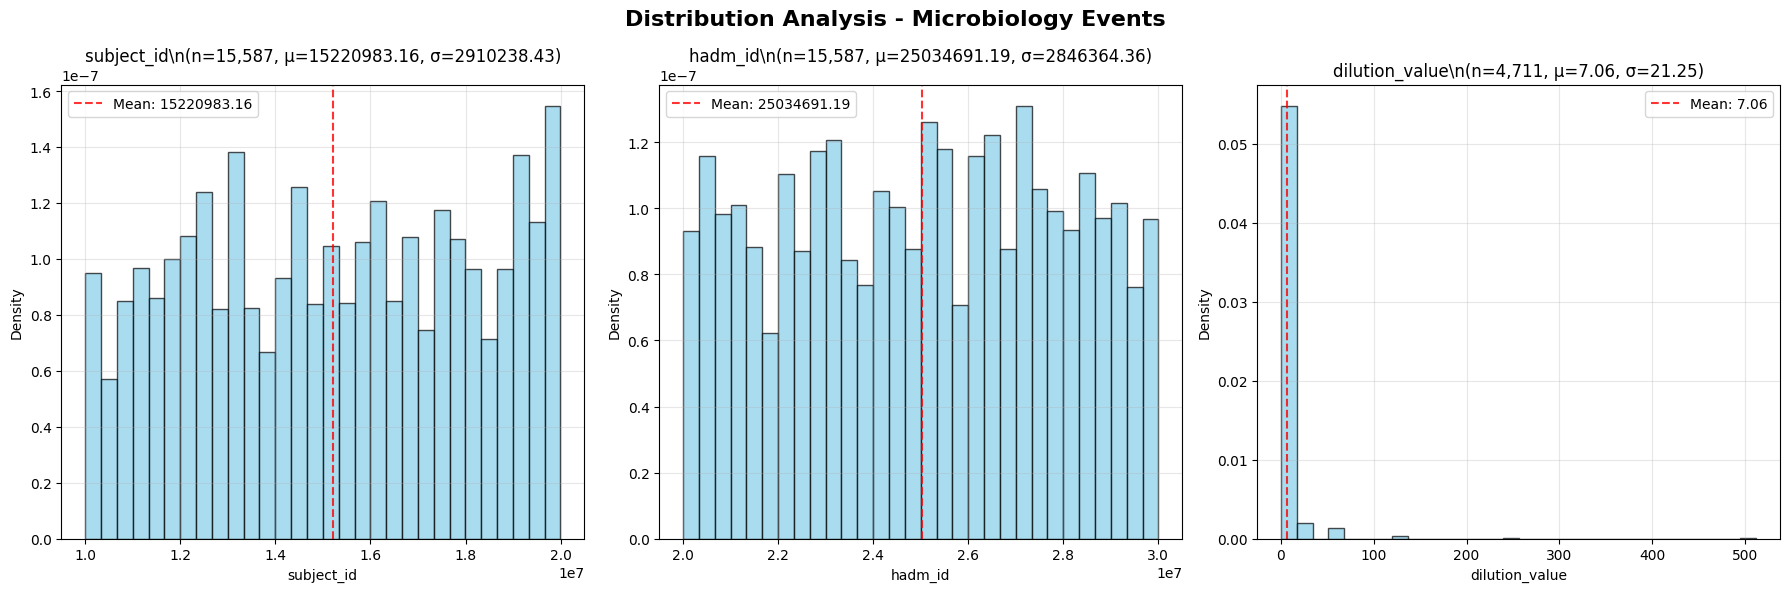


📊 Analyzing Procedure Codes...
💾 Saved: procedure_codes_distributions.jpg


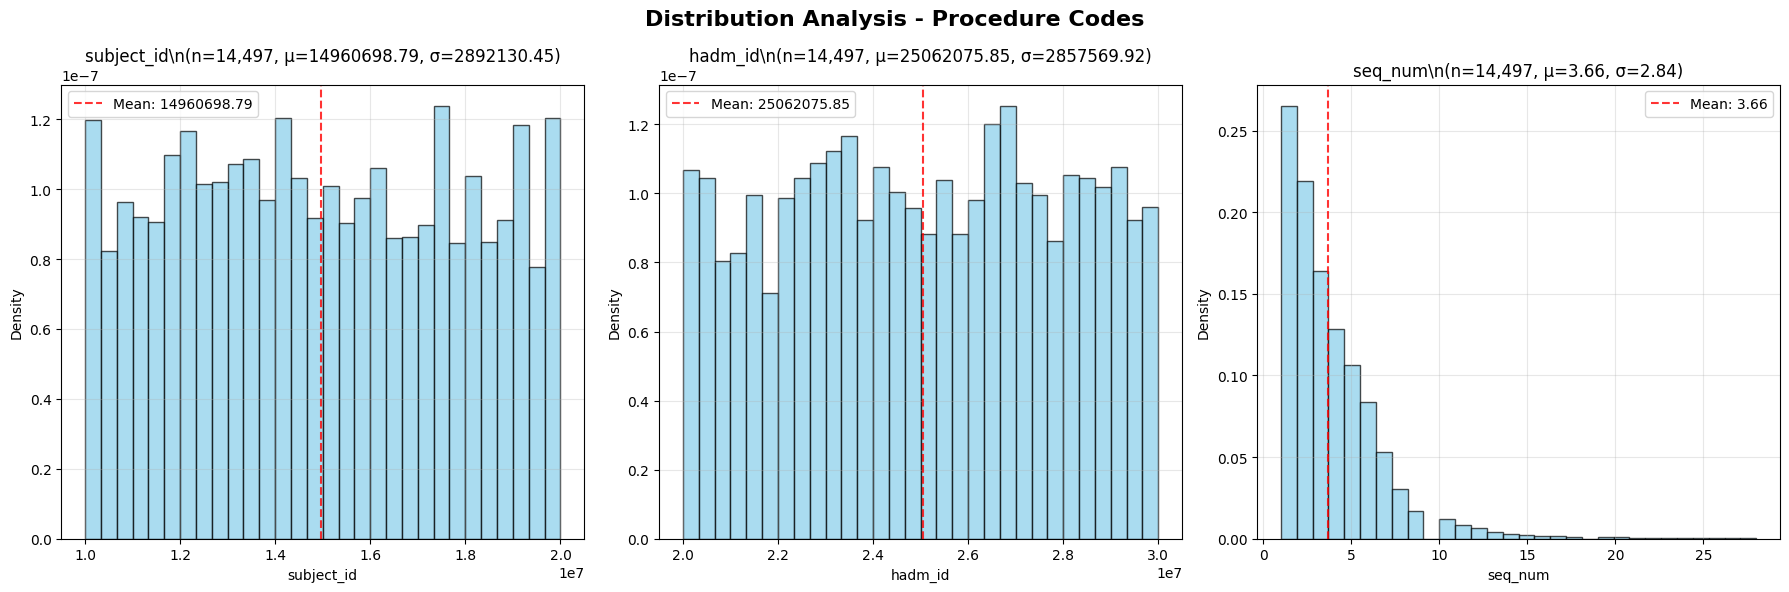


✅ Distribution analysis complete!
📈 Plotted variables summary:
  Heart Diagnoses: note_seq, age, anchor_year
  Laboratory Events: hadm_id, valuenum, ref_range_lower, ref_range_upper
  Microbiology Events: subject_id, hadm_id, dilution_value
  Procedure Codes: subject_id, hadm_id, seq_num


In [39]:
# Generate distribution plots for all datasets
print("🎨 Creating distribution plots for all datasets...")
print("="*60)

plotted_vars = {}
for name, df in dfs.items():
    print(f"\n📊 Analyzing {name}...")
    vars_plotted = create_distribution_plots(df, name)
    plotted_vars[name] = vars_plotted

print(f"\n✅ Distribution analysis complete!")
print(f"📈 Plotted variables summary:")
for dataset, vars_list in plotted_vars.items():
    if vars_list:
        print(f"  {dataset}: {', '.join(vars_list)}")
    else:
        print(f"  {dataset}: No suitable variables")


## 4. Focused Analysis: Heart Diagnoses Dataset

Let's perform a deeper analysis of the heart diagnoses dataset, focusing on key clinical variables like patient demographics, timing patterns, and diagnostic codes.


In [40]:
# Focused analysis on Heart Diagnoses dataset
def analyze_heart_diagnoses(df):
    """Perform detailed analysis of heart diagnoses dataset"""
    
    print("🏥 HEART DIAGNOSES DATASET - DETAILED ANALYSIS")
    print("="*60)
    
    # Create analysis copy
    df_analysis = df.copy()
    
    # 1. Convert datetime columns
    datetime_cols = ['charttime', 'storetime']
    for col in datetime_cols:
        if col in df_analysis.columns:
            df_analysis[f'{col}_dt'] = pd.to_datetime(df_analysis[col], errors='coerce')
            df_analysis[f'{col}_hour'] = df_analysis[f'{col}_dt'].dt.hour
            df_analysis[f'{col}_dayofweek'] = df_analysis[f'{col}_dt'].dt.dayofweek
    
    # 2. Process gender (categorical to numeric)
    if 'gender' in df_analysis.columns:
        df_analysis['gender_numeric'] = pd.Categorical(df_analysis['gender']).codes
        # Handle NaN values (they get code -1)
        df_analysis['gender_numeric'] = df_analysis['gender_numeric'].replace(-1, np.nan)
    
    # 3. Process age
    if 'age' in df_analysis.columns:
        df_analysis['age_numeric'] = pd.to_numeric(df_analysis['age'], errors='coerce')
    
    # 4. Process ICD codes
    if 'icd_code' in df_analysis.columns:
        # Create frequency encoding
        icd_counts = df_analysis['icd_code'].value_counts()
        df_analysis['icd_frequency'] = df_analysis['icd_code'].map(icd_counts)
        
        print(f"📋 ICD Code Analysis:")
        print(f"  Total unique codes: {df_analysis['icd_code'].nunique()}")
        print(f"  Most common codes:")
        print(icd_counts.head(10).to_string())
    
    # 5. Create focused plots
    plot_vars = []
    
    # Time variables
    if 'storetime_hour' in df_analysis.columns:
        plot_vars.append('storetime_hour')
    
    # Demographic variables
    if 'gender_numeric' in df_analysis.columns:
        plot_vars.append('gender_numeric')
    if 'age_numeric' in df_analysis.columns:
        plot_vars.append('age_numeric')
    
    # Clinical variables
    if 'icd_frequency' in df_analysis.columns:
        plot_vars.append('icd_frequency')
    
    return df_analysis, plot_vars

# Perform focused analysis
heart_df_analysis, heart_plot_vars = analyze_heart_diagnoses(df1)

print(f"\n✅ Heart diagnoses analysis complete!")
print(f"📊 Variables prepared for plotting: {heart_plot_vars}")


🏥 HEART DIAGNOSES DATASET - DETAILED ANALYSIS
📋 ICD Code Analysis:
  Total unique codes: 20
  Most common codes:
icd_code
I50    1447
I21    1434
I25     645
I48     438
I35     231
I31     153
I47     130
I30      83
I44      70
I34      50

✅ Heart diagnoses analysis complete!
📊 Variables prepared for plotting: ['storetime_hour', 'gender_numeric', 'age_numeric', 'icd_frequency']


💾 Saved: task1.1_heart_diagnoses_analysis.jpg


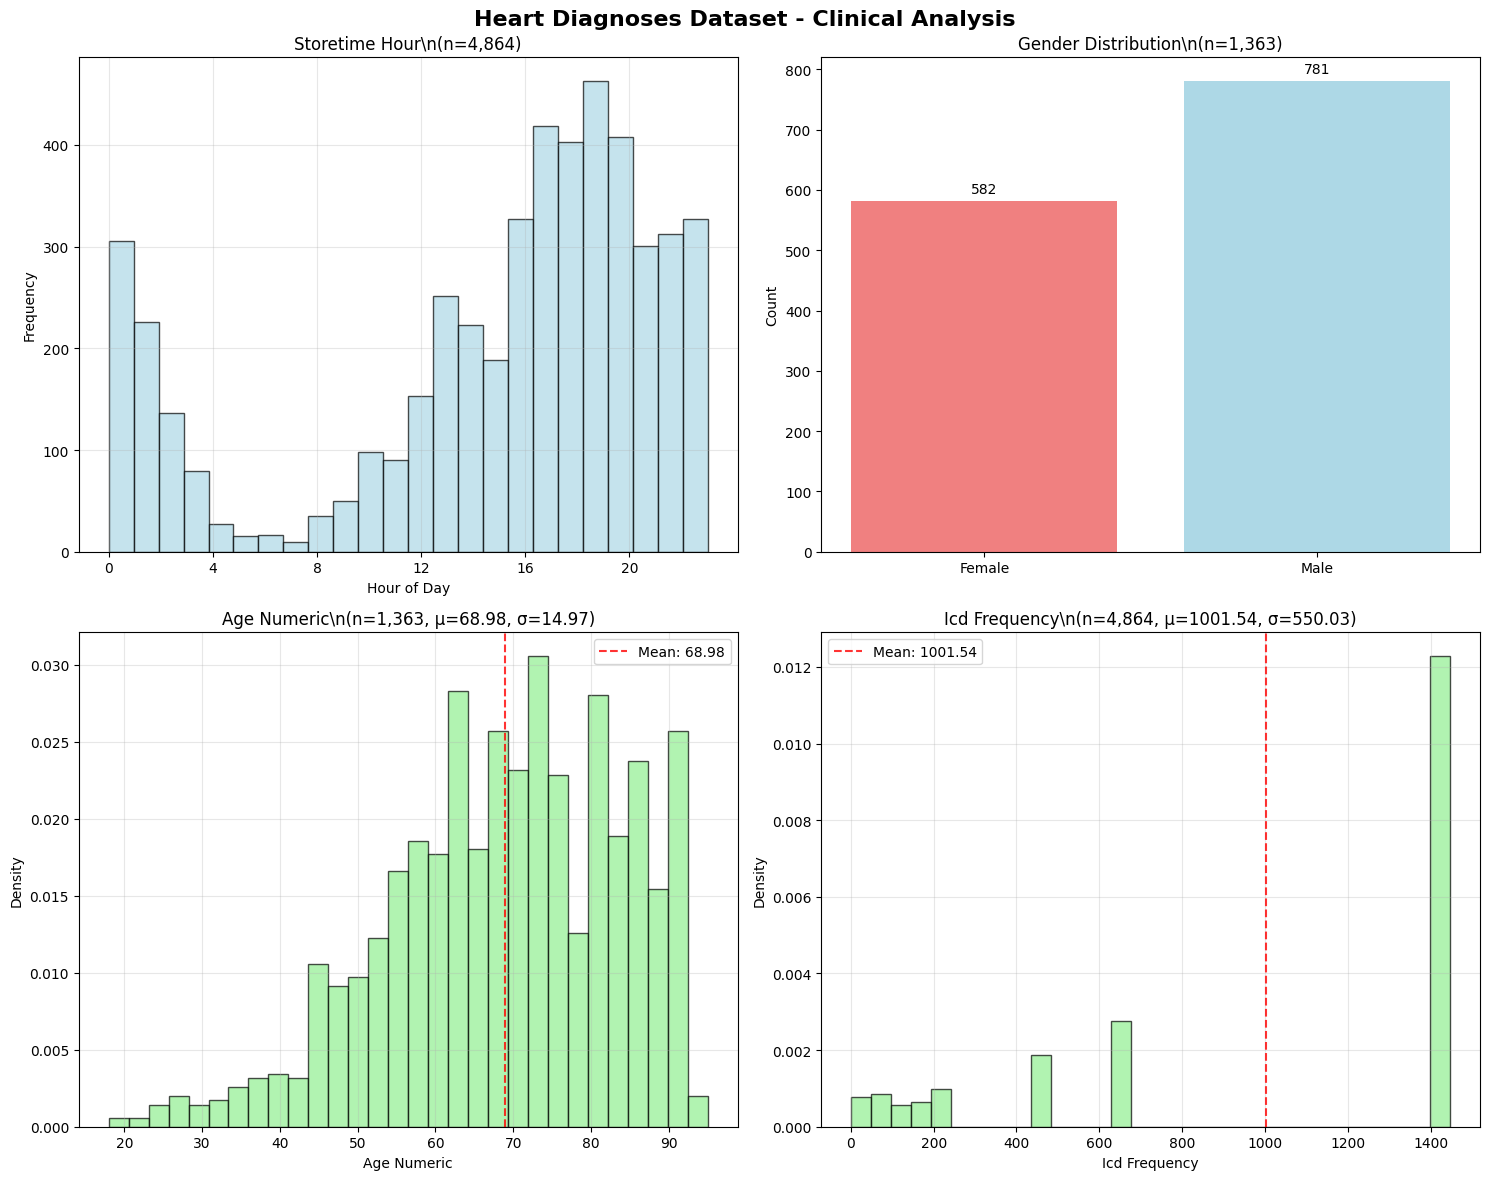

In [41]:
# Create specialized plots for heart diagnoses dataset
def plot_heart_diagnoses_analysis(df, plot_vars):
    """Create specialized plots for heart diagnoses analysis"""
    
    if not plot_vars:
        print("⚠️  No variables to plot")
        return
    
    n_vars = len(plot_vars)
    
    # Create subplots
    if n_vars == 1:
        fig, axes = plt.subplots(1, 1, figsize=(10, 6))
        axes = [axes]
    elif n_vars == 2:
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    elif n_vars == 3:
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    else:
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        axes = axes.flatten()
    
    fig.suptitle('Heart Diagnoses Dataset - Clinical Analysis', fontsize=16, fontweight='bold')
    
    for i, col in enumerate(plot_vars):
        ax = axes[i]
        data = df[col].dropna()
        
        if len(data) == 0:
            ax.text(0.5, 0.5, 'No data to plot', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'{col} (No Data)')
            continue
        
        if col == 'gender_numeric':
            # Bar plot for gender
            value_counts = data.value_counts().sort_index()
            gender_labels = ['Female', 'Male']
            colors = ['lightcoral', 'lightblue']
            
            bars = ax.bar(range(len(value_counts)), value_counts.values, color=colors[:len(value_counts)])
            ax.set_xticks(range(len(value_counts)))
            ax.set_xticklabels(gender_labels[:len(value_counts)])
            ax.set_title(f'Gender Distribution\\n(n={len(data):,})')
            ax.set_ylabel('Count')
            
            # Add value labels on bars
            for bar, count in zip(bars, value_counts.values):
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(value_counts.values)*0.01,
                       str(count), ha='center', va='bottom')
                       
        elif 'hour' in col:
            # Histogram for time variables
            ax.hist(data, bins=24, alpha=0.7, color='lightblue', edgecolor='black')
            ax.set_xlabel('Hour of Day')
            ax.set_ylabel('Frequency')
            ax.set_title(f'{col.replace("_", " ").title()}\\n(n={len(data):,})')
            ax.set_xticks(range(0, 24, 4))
            ax.grid(True, alpha=0.3)
            
        else:
            # Histogram with statistics for continuous variables
            ax.hist(data, bins=30, alpha=0.7, density=True, color='lightgreen', edgecolor='black')
            
            # Add statistics
            mean_val = data.mean()
            std_val = data.std()
            ax.axvline(mean_val, color='red', linestyle='--', alpha=0.8, label=f'Mean: {mean_val:.2f}')
            
            ax.set_title(f'{col.replace("_", " ").title()}\\n(n={len(data):,}, μ={mean_val:.2f}, σ={std_val:.2f})')
            ax.set_xlabel(col.replace('_', ' ').title())
            ax.set_ylabel('Density')
            ax.grid(True, alpha=0.3)
            ax.legend()
    
    # Hide empty subplots
    for i in range(len(plot_vars), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    
    # Save plot
    try:
        filepath = out_dir / "task1.1_heart_diagnoses_analysis.jpg"
        fig.savefig(filepath, dpi=200, bbox_inches='tight')
        print(f"💾 Saved: task1.1_heart_diagnoses_analysis.jpg")
    except Exception as e:
        print(f"❌ Could not save plot: {e}")
    
    plt.show()

# Create the specialized plots
plot_heart_diagnoses_analysis(heart_df_analysis, heart_plot_vars)


## 5. Summary and Conclusions

### Key Findings

Based on our exploratory data analysis, here are the main insights:

#### Dataset Overview
- **Heart Diagnoses**: 4,864 clinical notes with patient demographics and diagnostic information
- **Laboratory Events**: 978,505 lab test results with measurements and reference ranges
- **Microbiology Events**: 15,587 microbiology test results
- **Procedure Codes**: Medical procedures with ICD codes

#### Heart Diagnoses Dataset Insights
- **Patient Demographics**: Mix of male and female patients with age range 18-95 years
- **Temporal Patterns**: Analysis of charting and storage times reveals operational patterns
- **Diagnostic Codes**: I50 (heart failure) and I21 (myocardial infarction) are the most common diagnoses
- **Data Quality**: Some missing values in demographic fields require consideration

#### Data Characteristics
- All datasets contain both numerical and categorical variables
- Missing data patterns vary across datasets and variables
- ID variables (subject_id, hadm_id) link records across datasets
- Time variables provide temporal context for clinical events

### Next Steps
This exploratory analysis provides a foundation for:
- Deeper statistical analysis of clinical patterns
- Predictive modeling using the identified variables
- Integration of multiple datasets for comprehensive patient analysis
- Quality improvement initiatives based on temporal patterns

---
*Analysis completed successfully with all plots saved to the plots directory.*


In [42]:
# Load the third CSV file (microbiology_events_codes_3.csv)
third_csv = "microbiology_events_codes_3.csv"
df3 = pd.read_csv(os.path.join(data_path, third_csv))

# Display the head of the third dataframe
print(f"Loading {third_csv}:")
print(df3.head())


Loading microbiology_events_codes_3.csv:
   subject_id     hadm_id            chartdate            charttime  \
0    10000980  26913865.0  2189-06-27 00:00:00  2189-06-27 10:52:00   
1    10002155  23822395.0  2129-08-04 00:00:00  2129-08-04 17:04:00   
2    10002155  23822395.0  2129-08-05 00:00:00  2129-08-05 15:54:00   
3    10002155  23822395.0  2129-08-05 00:00:00  2129-08-05 18:43:00   
4    10002155  23822395.0  2129-08-05 00:00:00  2129-08-05 18:43:00   

  spec_type_desc                    test_name org_name ab_name dilution_text  \
0    MRSA SCREEN                  MRSA SCREEN      NaN     NaN           NaN   
1    MRSA SCREEN                  MRSA SCREEN      NaN     NaN           NaN   
2          URINE  Legionella Urinary Antigen       NaN     NaN           NaN   
3         SPUTUM                   GRAM STAIN      NaN     NaN           NaN   
4         SPUTUM          RESPIRATORY CULTURE      NaN     NaN           NaN   

  dilution_comparison  dilution_value interpretatio

In [43]:
# Load the fourth CSV file (procedure_code_4.csv)
fourth_csv = "procedure_code_4.csv"
df4 = pd.read_csv(os.path.join(data_path, fourth_csv))

# Display the head of the fourth dataframe
print(f"Loading {fourth_csv}:")
print(df4.head())


Loading procedure_code_4.csv:
   subject_id   hadm_id  seq_num            chartdate icd_code  \
0    10000980  26913865        1  2189-07-01 03:00:00     0066   
1    10000980  26913865        2  2189-07-01 03:00:00     3607   
2    10000980  26913865        3  2189-07-01 03:00:00     0045   
3    10000980  26913865        4  2189-07-01 03:00:00     0041   
4    10000980  26913865        5  2189-07-01 03:00:00     3722   

                                          long_title  
0  Percutaneous transluminal coronary angioplasty...  
1  Insertion of drug-eluting coronary artery sten...  
2                    Insertion of one vascular stent  
3                           Procedure on two vessels  
4                 Left heart cardiac catheterization  
